# Caollect Data and Train Gaussian Processes

## Setup and imports

In [9]:
# ===============================================
# 1️⃣ Setup e imports
# ===============================================
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import time, os
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

from models.cantilever_2d_drone import get_xml  # tu generador XML

# Configuración base de MuJoCo
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

# Función para hacer un paso en la simulación
def step_sim(data, ctrl):
    data.ctrl[:] = ctrl
    mj.mj_step(model, data)
    return np.array([
        data.sensor("pos_drone").data[0],   # x
        data.sensor("pos_drone").data[2],   # z
        data.qvel[0],                       # x'
        data.qvel[2],                       # z'
        data.qpos[1],                       # θ (asumiendo 2° DoF rotacional)
        data.qvel[1],                       # θ'
    ])

print("✅ Simulador inicializado correctamente.")


✅ Simulador inicializado correctamente.


## Data collection

In [41]:
# ===============================================
# 2️⃣ Recolección de datos del simulador
# ===============================================

# Función para "desenvolver" ángulos
def unwrap_angle(angle_raw, angle_prev):
    """
    Devuelve un ángulo continuo, sin saltos, extendiendo más allá de [-π, π].
    """
    if angle_prev is None:
        return angle_raw

    # diferencia cruda
    delta = angle_raw - angle_prev

    # si cruzó el límite, corrige ±2π
    if delta > np.pi:
        angle_raw -= 2*np.pi
    elif delta < -np.pi:
        angle_raw += 2*np.pi

    return angle_raw


# Función para convertir cuaternión a ángulo de pitch (Y)
def quat_to_pitch_y(quat, prev_roll=None):
    w, x, y, z = quat

    # roll (X)
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)

    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None, dt=0.01):
    # --- Posición global ---
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = pos[0], pos[2]

    # --- Velocidades lineales del cuerpo (provenientes de MuJoCo) ---
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = linvel[0]
    z_dot = linvel[2]

    # --- Cuaternión del dron ---
    quat = data.sensor("quat_drone").data   # [w,x,y,z]

    # --- Roll instantáneo ---
    roll_raw = quat_to_pitch_y(quat)

    # --- Roll continuo con unwrap ---
    if prev_theta is None:
        theta = roll_raw
    else:
        delta = roll_raw - prev_theta
        if delta > np.pi:
            roll_raw -= 2*np.pi
        elif delta < -np.pi:
            roll_raw += 2*np.pi
        theta = roll_raw

    # --- Velocidad angular: eje X = roll ---
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    theta_dot = angvel[1]   # solo el roll

    state = np.array([x, z, x_dot, z_dot, theta, theta_dot])
    return state, theta





def rollout_random(model, data, n_steps=10000, dt=0.01):
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states, actions, next_states = [], [], []
    prev_theta = None

    for step in tqdm(range(n_steps)):
        # Estado actual
        s_t, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        # Acción aleatoria
        a_t = np.random.uniform(0.0, step/n_steps*2.0, size=2) # fuerza entre 0 y 2*N, escalada con el tiempo
        data.ctrl[:] = a_t

        # Avanzar simulación
        mj.mj_step(model, data)

        # Estado siguiente
        s_next, prev_theta = get_state_from_sensors(data, prev_theta, dt)

        states.append(s_t)
        actions.append(a_t)
        next_states.append(s_next)

    return np.array(states), np.array(actions), np.array(next_states)





# Ejecutar recolección
states, actions, next_states = rollout_random(model, data, n_steps=100000, dt=0.01)

# Guardar diferencias (delta_s)
delta_s = next_states - states

print("✅ Datos recolectados:", states.shape, actions.shape, delta_s.shape)


100%|██████████| 100000/100000 [00:03<00:00, 29048.24it/s]

✅ Datos recolectados: (100000, 6) (100000, 2) (100000, 6)


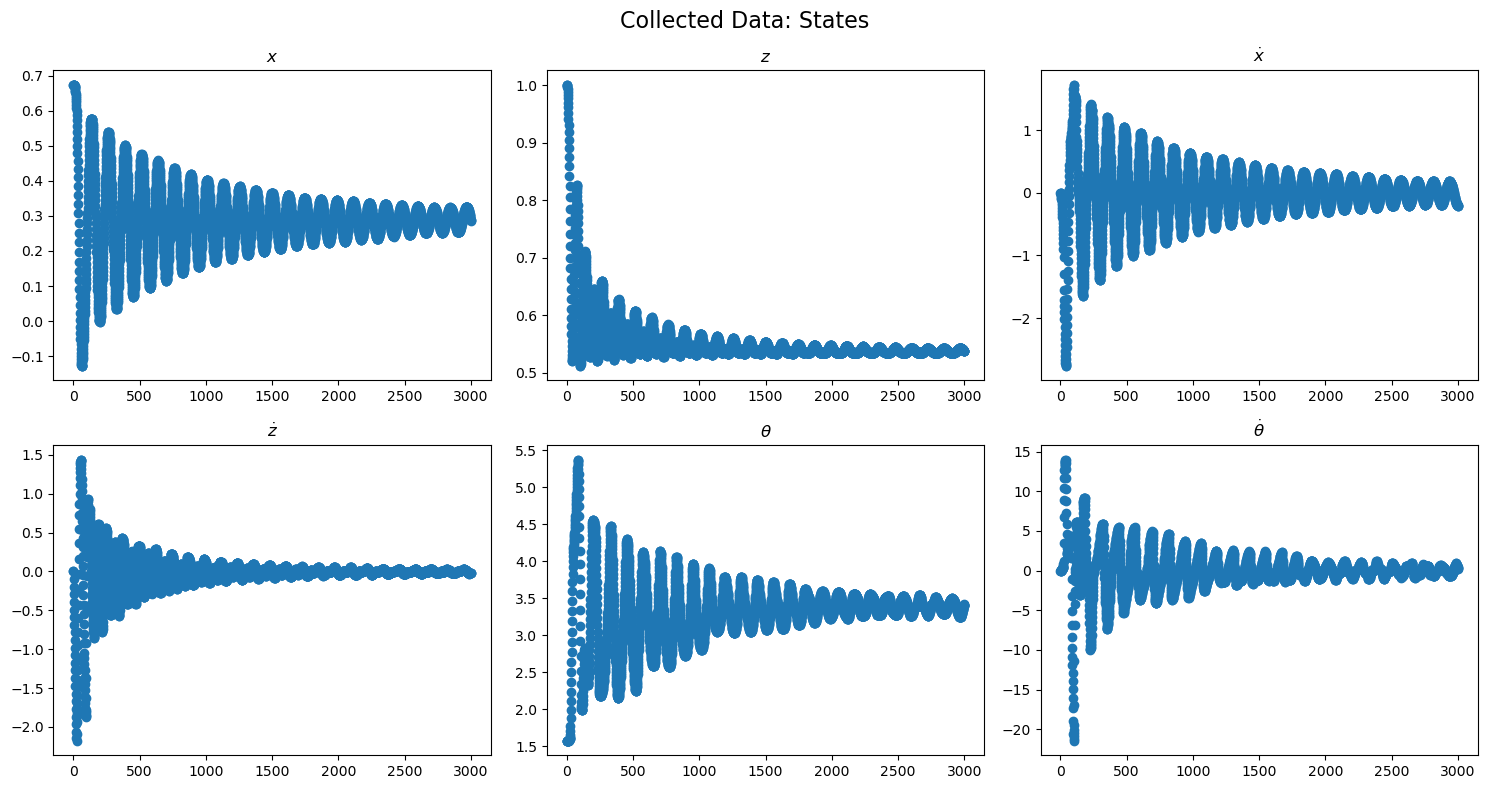

In [158]:
# ===============================================
# 3️⃣ Visualización de los datos recolectados
# ===============================================

rng = 3000
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0,rng,rng),states[0:rng,i])
    ax.set_title(f"{labels[i]}")

plt.suptitle("Collected Data: States", fontsize=16)
plt.tight_layout()
plt.show()



## Neural Network Training

In [36]:

#===============================================
# 4️⃣ Preparación de datos para entrenamiento de NN
#===============================================

import numpy as np

# A partir de tu data collection:
# states, actions, next_states = rollout_random(...)
delta_s = next_states - states

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
act_dim   = 2   # [u_left, u_right]

X_nn = np.hstack([states, actions])   # (N, 8)
Y_nn = delta_s                        # (N, 6)

print("X_nn:", X_nn.shape, "Y_nn:", Y_nn.shape)

# Normalización
X_mean = X_nn.mean(axis=0, keepdims=True)
X_std  = X_nn.std(axis=0, keepdims=True) + 1e-8

Y_mean = Y_nn.mean(axis=0, keepdims=True)
Y_std  = Y_nn.std(axis=0, keepdims=True) + 1e-8

X_norm = (X_nn - X_mean) / X_std
Y_norm = (Y_nn - Y_mean) / Y_std

print("X_norm:", X_norm.shape, "Y_norm:", Y_norm.shape)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

N_total = X_norm.shape[0]
perm = np.random.permutation(N_total)
train_ratio = 0.8
split_idx = int(train_ratio * N_total)

train_idx = perm[:split_idx]
val_idx   = perm[split_idx:]

X_train = X_norm[train_idx]
Y_train = Y_norm[train_idx]
X_val   = X_norm[val_idx]
Y_val   = Y_norm[val_idx]

print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape,   Y_val.shape)

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset   = TensorDataset(X_val_t,   Y_val_t)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)



X_nn: (100000, 8) Y_nn: (100000, 6)
X_norm: (100000, 8) Y_norm: (100000, 6)
device: cuda
Train: (80000, 8) (80000, 6)
Val:   (20000, 8) (20000, 6)


In [159]:
#===============================================
# 5️⃣ Definición del modelo y LOAD/SAVE automáticos
#===============================================

import os
import torch
import torch.nn as nn
import torch.optim as optim

model_dir = "data/nn_models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "dyn_net.pth")
norm_path  = os.path.join(model_dir, "normalization.npz")

input_dim  = state_dim + act_dim   # 8
output_dim = state_dim             # 6

class DynNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

dyn_net = DynNet(input_dim, output_dim).to(device)
optimizer = optim.Adam(dyn_net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ===============================================
# 🟢 1) Intentar cargar modelo existente
# ===============================================
if os.path.exists(model_path) and os.path.exists(norm_path):
    print("📂 Cargando modelo neuronal guardado...")

    # cargar pesos
    dyn_net.load_state_dict(torch.load(model_path, map_location=device))

    # cargar normalización
    norm = np.load(norm_path)
    X_mean = norm["X_mean"]
    X_std  = norm["X_std"]
    Y_mean = norm["Y_mean"]
    Y_std  = norm["Y_std"]

    # convertir a tensores en device
    X_mean_t = torch.tensor(X_mean, dtype=torch.float32, device=device)
    X_std_t  = torch.tensor(X_std, dtype=torch.float32, device=device)
    Y_mean_t = torch.tensor(Y_mean, dtype=torch.float32, device=device)
    Y_std_t  = torch.tensor(Y_std, dtype=torch.float32, device=device)

    print("✅ Modelo cargado.")
    load_success = True

else:
    print("⚙️ Entrenando nuevo modelo neuronal...")
    load_success = False

# ===============================================
# 🟡 2) Entrenar solo si NO existe
# ===============================================
if not load_success:

    n_epochs = 100
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # ---- TRAIN ----
        dyn_net.train()
        running_train = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            y_pred = dyn_net(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()

            running_train += loss.item() * xb.size(0)

        epoch_train = running_train / len(train_dataset)

        # ---- VALIDATION ----
        dyn_net.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                y_pred = dyn_net(xb)
                loss = criterion(y_pred, yb)
                running_val += loss.item() * xb.size(0)

        epoch_val = running_val / len(val_dataset)

        train_losses.append(epoch_train)
        val_losses.append(epoch_val)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | "
                  f"train_loss={epoch_train:.6e} | val_loss={epoch_val:.6e}")

    # ------------------------------
    # Guardar modelo entrenado
    # ------------------------------
    torch.save(dyn_net.state_dict(), model_path)

    np.savez(norm_path,
             X_mean=X_mean,
             X_std=X_std,
             Y_mean=Y_mean,
             Y_std=Y_std)

    print("💾 Modelo neuronal guardado en:", model_path)
    print("💾 Normalización guardada en:", norm_path)

    # ------------------------------
    # Plot losses
    # ------------------------------
    import matplotlib.pyplot as plt

    epochs = np.arange(1, n_epochs+1)

    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label="Train loss")
    plt.plot(epochs, val_losses, label="Val loss")
    plt.xlabel("Época")
    plt.ylabel("MSE (normalizado)")
    plt.title("Evolución de pérdidas – red de dinámica")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



📂 Cargando modelo neuronal guardado...
✅ Modelo cargado.


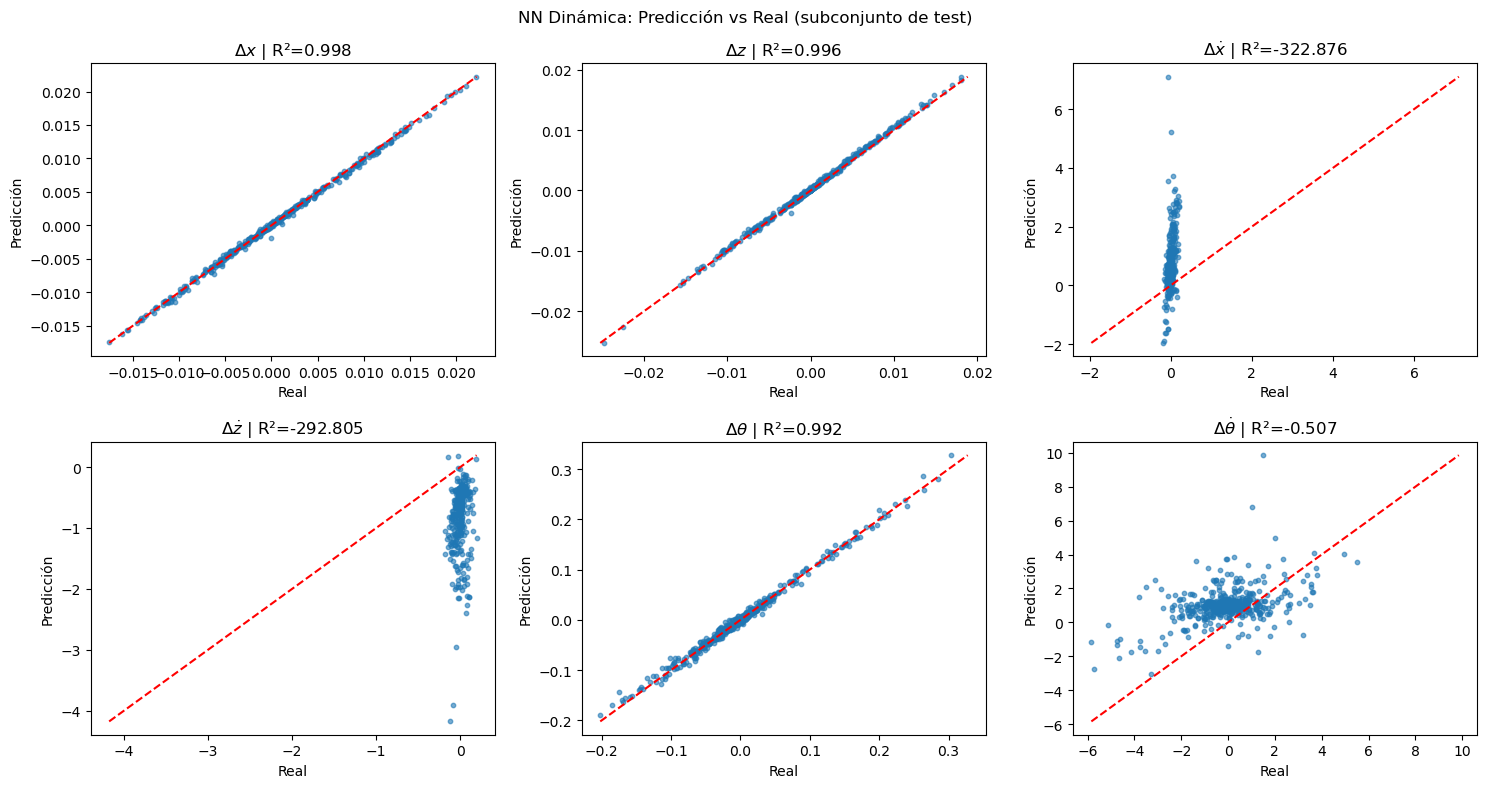

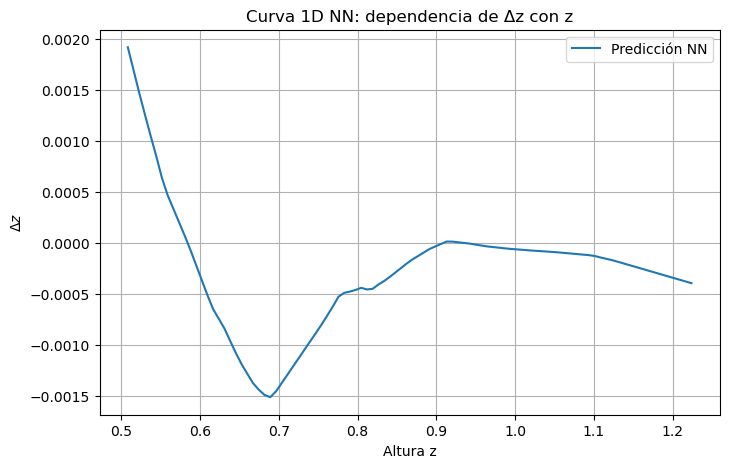

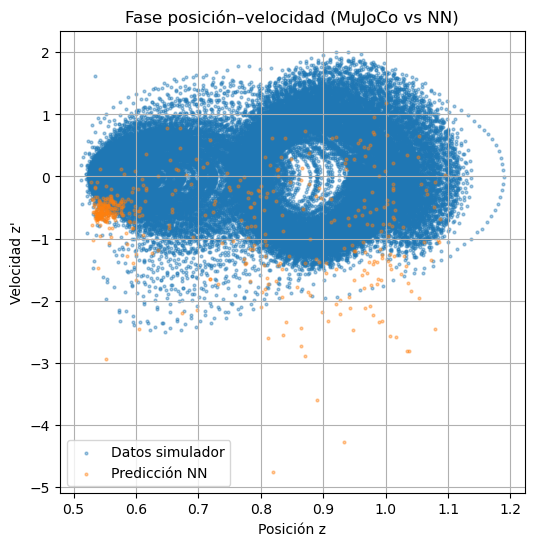

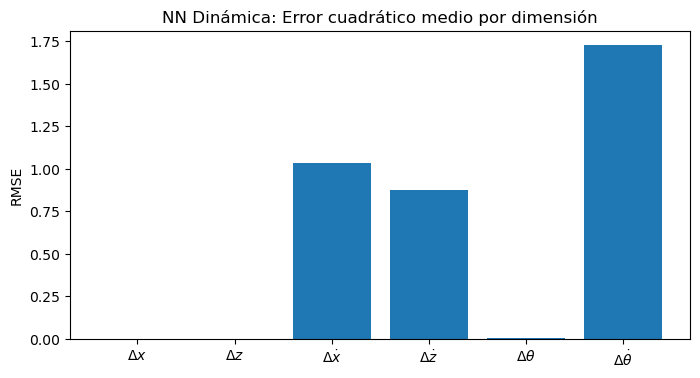

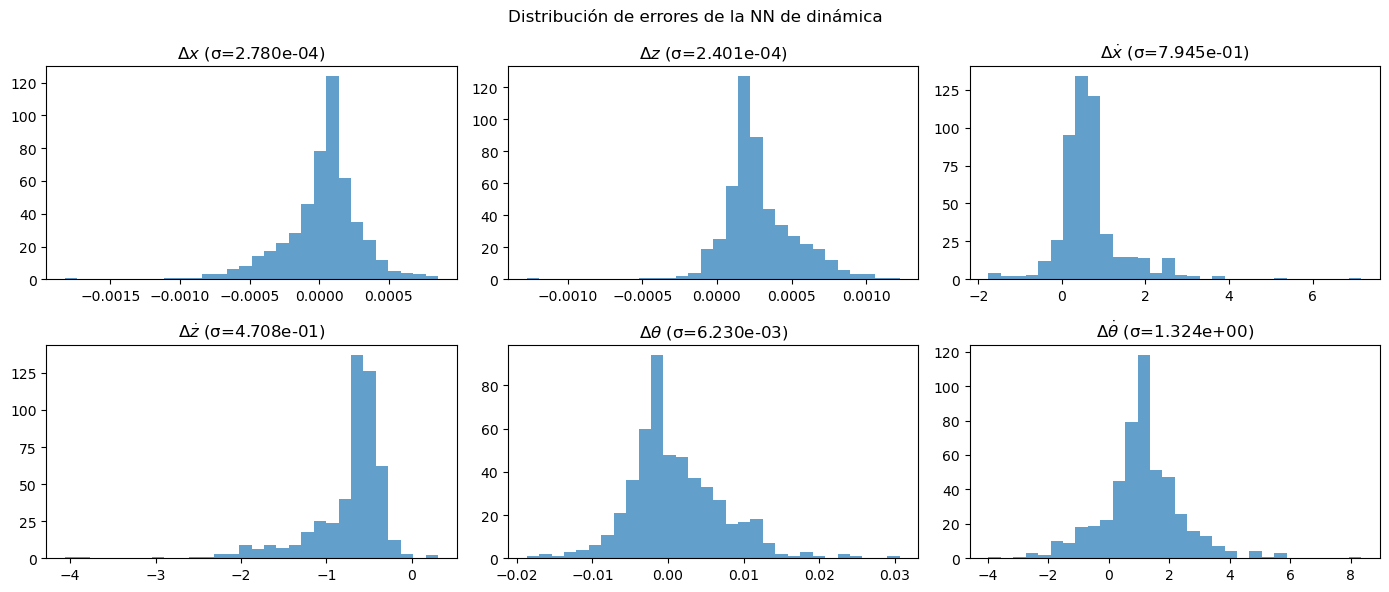

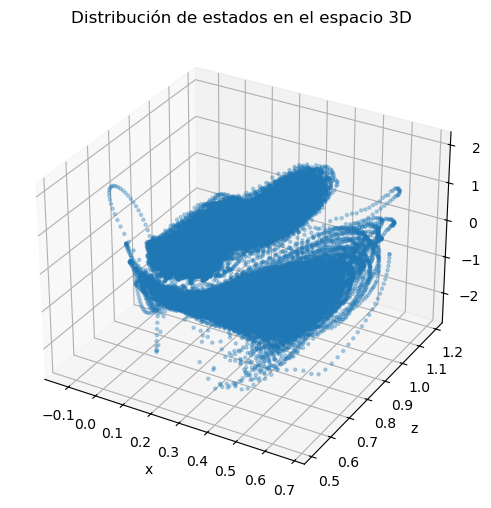

In [160]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
import numpy as np

dyn_net.eval()

# Tensores de normalización (si aún no los tienes en GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_mean_t = torch.tensor(X_mean, dtype=torch.float32, device=device)
X_std_t  = torch.tensor(X_std,  dtype=torch.float32, device=device)
Y_mean_t = torch.tensor(Y_mean, dtype=torch.float32, device=device)
Y_std_t  = torch.tensor(Y_std,  dtype=torch.float32, device=device)

# --------------------------
# 1️⃣ Scatter: Pred vs Real
# --------------------------

# Subconjunto de test
N_total = X_nn.shape[0]
n_test  = min(500, N_total)
idx = np.random.choice(N_total, size=n_test, replace=False)

X_test = X_nn[idx]   # (n_test, 8)
Y_true = Y_nn[idx]   # (n_test, 6)

with torch.no_grad():
    x_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
    x_test_n = (x_test_t - X_mean_t) / X_std_t
    y_pred_n = dyn_net(x_test_n)
    y_pred_t = y_pred_n * Y_std_t + Y_mean_t   # des-normalizar Δs
    Y_pred = y_pred_t.cpu().numpy()

labels = [r'$\Delta x$', r'$\Delta z$', r'$\Delta \dot{x}$',
          r'$\Delta \dot{z}$', r'$\Delta \theta$', r'$\Delta \dot{\theta}$']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_true[:, i], Y_pred[:, i], s=10, alpha=0.6)
    min_val = min(Y_true[:, i].min(), Y_pred[:, i].min())
    max_val = max(Y_true[:, i].max(), Y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax.set_title(f"{labels[i]} | R²={r2_score(Y_true[:, i], Y_pred[:, i]):.3f}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicción")

plt.suptitle("NN Dinámica: Predicción vs Real (subconjunto de test)")
plt.tight_layout()
plt.show()

# --------------------------
# 2️⃣ Curva 1D (dependencia con z)
#    (sin incertidumbre explícita)
# --------------------------

var_idx = 1  # por ejemplo, Δz
dim = 1      # X_nn[:,1] corresponde a z en el estado

z_values = np.linspace(X_nn[:, dim].min(), X_nn[:, dim].max(), 100)

X_base = X_nn.mean(axis=0)
X_curve = np.tile(X_base, (100, 1))
X_curve[:, dim] = z_values

with torch.no_grad():
    x_curve_t = torch.tensor(X_curve, dtype=torch.float32, device=device)
    x_curve_n = (x_curve_t - X_mean_t) / X_std_t
    y_curve_n = dyn_net(x_curve_n)
    y_curve_t = y_curve_n * Y_std_t + Y_mean_t
    y_mean = y_curve_t[:, var_idx].cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(z_values, y_mean, label='Predicción NN')
plt.xlabel("Altura z")
plt.ylabel(labels[var_idx])
plt.title("Curva 1D NN: dependencia de Δz con z")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Fase: posición vs velocidad (modelo vs datos)
#     Usamos Δż (índice 3) para predecir ż_{t+1}
# --------------------------

plt.figure(figsize=(6,6))
# Datos reales
plt.scatter(states[:,1], states[:,3], s=4, alpha=0.4, label="Datos simulador")

# Predicciones NN sobre el subconjunto idx
z_real = states[idx, 1]
z_dot_real = states[idx, 3]
z_dot_pred = z_dot_real + Y_pred[:,3]  # z'_{t+1} = z' + Δz'

plt.scatter(z_real, z_dot_pred, s=4, alpha=0.4, label="Predicción NN")
plt.xlabel("Posición z")
plt.ylabel("Velocidad z'")
plt.title("Fase posición–velocidad (MuJoCo vs NN)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4️⃣ Errores por variable (RMSE)
# --------------------------

errors = Y_pred - Y_true   # (n_test, 6)
rmse = np.sqrt(np.mean(errors**2, axis=0))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(range(6), rmse)
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel("RMSE")
ax.set_title("NN Dinámica: Error cuadrático medio por dimensión")
plt.show()

# --------------------------
# 5️⃣ Distribución de errores (histogramas)
# --------------------------

fig, axes = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flat):
    ax.hist(errors[:,i], bins=30, alpha=0.7)
    ax.set_title(f"{labels[i]} (σ={np.std(errors[:,i]):.3e})")
plt.suptitle("Distribución de errores de la NN de dinámica")
plt.tight_layout()
plt.show()

# --------------------------
# 6️⃣ Visualización 3D de los estados (igual que antes)
# --------------------------
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(states[:,0], states[:,1], states[:,3], s=5, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("z'")
ax.set_title("Distribución de estados en el espacio 3D")
plt.show()


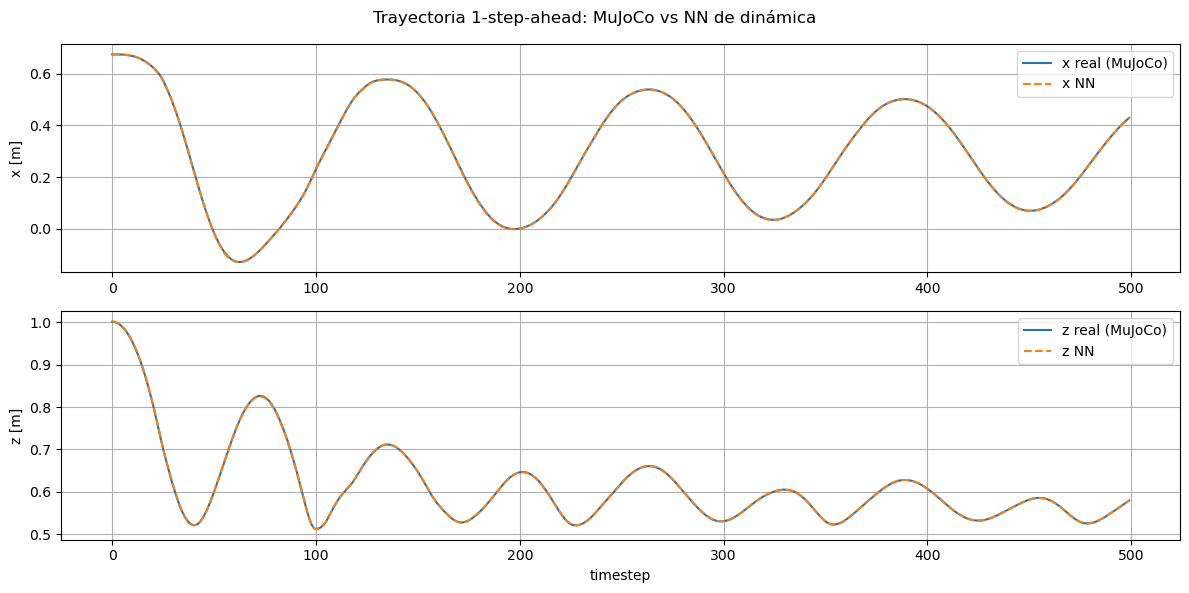

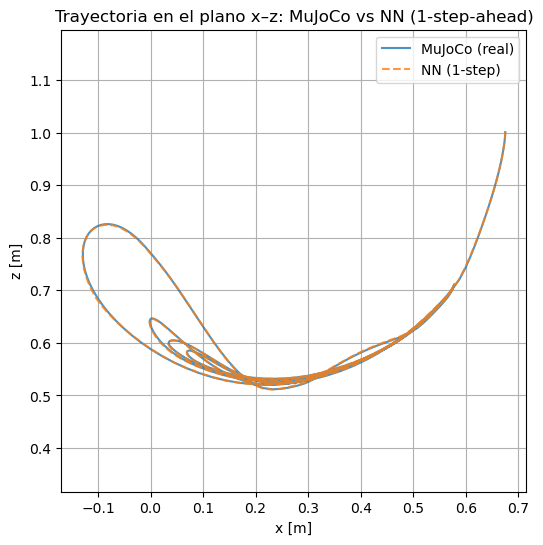

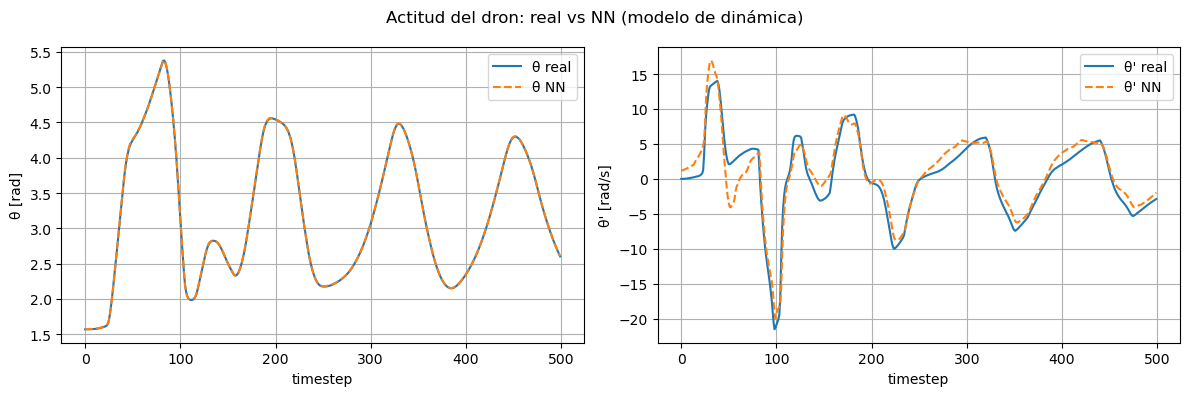

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import torch

dyn_net.eval()

# ===============================================
# 1️⃣ Elegimos una secuencia continua de índices
# ===============================================
t0 = 0
T = 500   # asegúrate de que t0+T+1 <= states.shape[0]

# Entradas (estado+acción)
X_seq = X_nn[t0:t0+T]        # (T, 8)
Y_seq_true = Y_nn[t0:t0+T]   # (T, 6) = Δs real

# Predicción de Δs con la red
with torch.no_grad():
    x_seq_t = torch.tensor(X_seq, dtype=torch.float32, device=device)
    # normalizar
    x_seq_n = (x_seq_t - X_mean_t) / X_std_t
    # predecir Δs normalizado
    y_seq_n = dyn_net(x_seq_n)
    # des-normalizar
    y_seq_t = y_seq_n * Y_std_t + Y_mean_t
    Y_seq_pred = y_seq_t.cpu().numpy()   # (T, 6)

# ===============================================
# 2️⃣ Reconstruimos el estado siguiente
# ===============================================
s_seq      = states[t0:t0+T]        # s_t      (T, 6)
s_seq_true = states[t0+1:t0+T+1]    # s_{t+1} real (T, 6)
s_seq_pred = s_seq + Y_seq_pred     # s_{t+1} predicho por NN

time = np.arange(T)

# ===============================================
# 3️⃣ Gráficos x(t), z(t): MuJoCo vs NN
# ===============================================
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, s_seq_true[:,0], label="x real (MuJoCo)")
plt.plot(time, s_seq_pred[:,0], '--', label="x NN")
plt.ylabel("x [m]")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_seq_true[:,1], label="z real (MuJoCo)")
plt.plot(time, s_seq_pred[:,1], '--', label="z NN")
plt.ylabel("z [m]")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Trayectoria 1-step-ahead: MuJoCo vs NN de dinámica")
plt.tight_layout()
plt.show()

# ===============================================
# 4️⃣ Trayectoria en el plano x–z
# ===============================================

plt.figure(figsize=(6,6))

# Trayectoria real (MuJoCo)
plt.plot(s_seq_true[:, 0],  # x
         s_seq_true[:, 1],  # z
         label="MuJoCo (real)", alpha=0.8)

# Trayectoria predicha por la NN (1-step-ahead)
plt.plot(s_seq_pred[:, 0],  # x
         s_seq_pred[:, 1],  # z
         '--', label="NN (1-step)", alpha=0.8)

plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("Trayectoria en el plano x–z: MuJoCo vs NN (1-step-ahead)")
plt.legend()
plt.grid(True)
plt.axis('equal')   # misma escala en x y z
plt.show()

# ==============================================
# 5️⃣ Visualización de actitudes (θ y θ') real vs NN
# ==============================================

plt.figure(figsize=(12,4))

# θ (roll)
plt.subplot(1,2,1)
plt.plot(time, s_seq_true[:,4], label="θ real")
plt.plot(time, s_seq_pred[:,4], '--', label="θ NN")
plt.xlabel("timestep")
plt.ylabel("θ [rad]")
plt.grid(True)
plt.legend()

# θ' (roll rate)
plt.subplot(1,2,2)
plt.plot(time, s_seq_true[:,5], label="θ' real")
plt.plot(time, s_seq_pred[:,5], '--', label="θ' NN")
plt.xlabel("timestep")
plt.ylabel("θ' [rad/s]")
plt.grid(True)
plt.legend()

plt.suptitle("Actitud del dron: real vs NN (modelo de dinámica)")
plt.tight_layout()
plt.show()




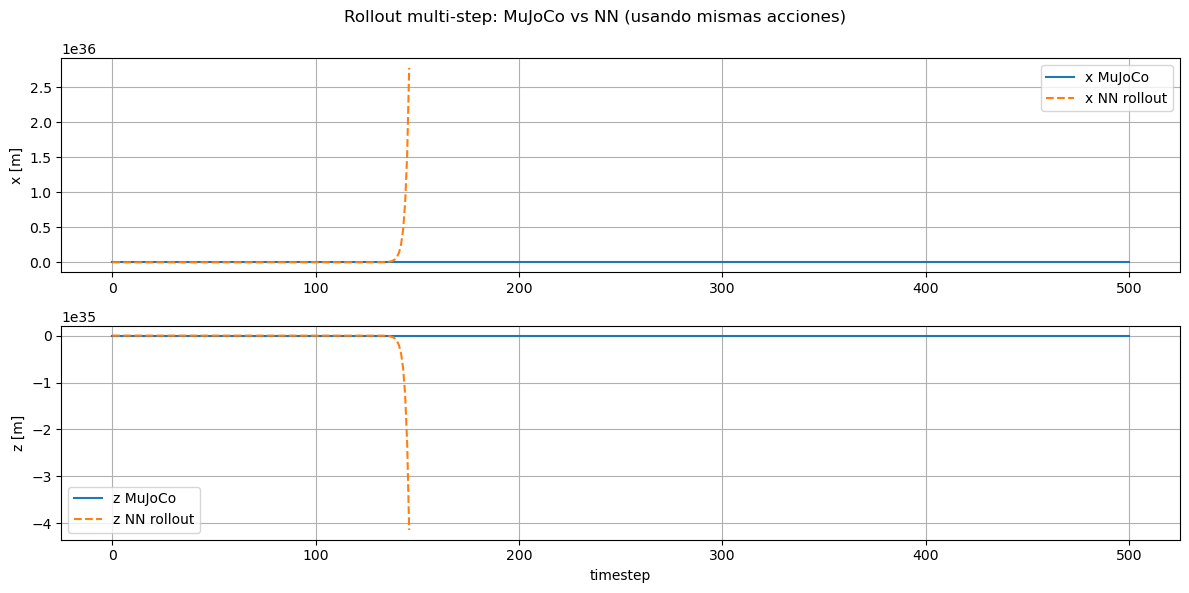

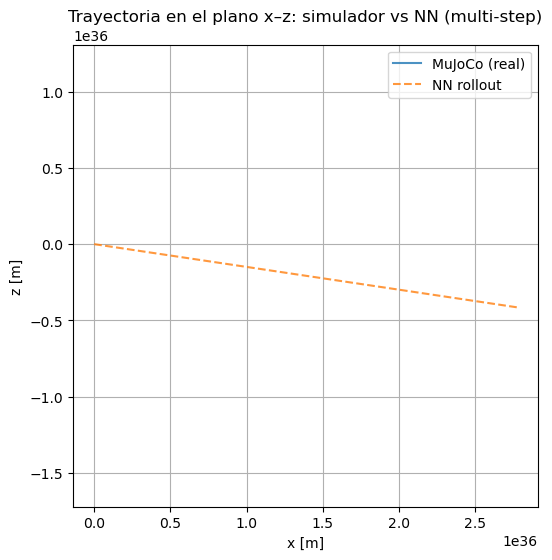

ValueError: x and y must have same first dimension, but have shapes (501,) and (500,)

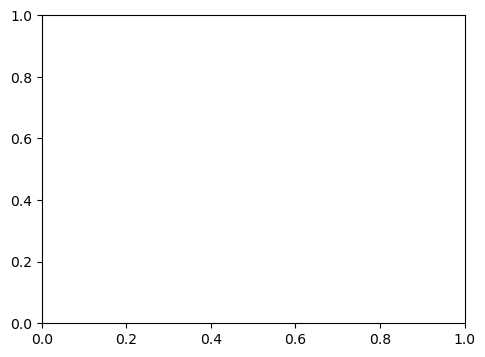

In [162]:
# ===============================================
# 5️⃣ Rollout multi-step usando el modelo NN
# ===============================================

dyn_net.eval()

t0 = 0   # puedes ajustar el punto de inicio
T  = 500    # longitud del rollout

s_true_traj = states[t0:t0+T+1]   # s_t ... s_{t+T}   (T+1, 6)
a_traj      = actions[t0:t0+T]    # a_t ... a_{t+T-1} (T,   2)

# Rollout de la NN
s_nn_list = [s_true_traj[0].copy()]   # empezamos en s_t0 real
s = s_true_traj[0].copy()

for k in range(T):
    s_k = s
    a_k = a_traj[k]
    x_in = np.hstack([s_k, a_k]).reshape(1, -1)   # (1, 8)

    with torch.no_grad():
        x_t = torch.tensor(x_in, dtype=torch.float32, device=device)
        # normalizar entrada
        x_n = (x_t - X_mean_t) / X_std_t
        # predecir Δs normalizado
        y_n = dyn_net(x_n)
        # des-normalizar
        y_t = y_n * Y_std_t + Y_mean_t
        delta_pred = y_t.cpu().numpy()[0]   # (6,)

    s = s_k + delta_pred
    s_nn_list.append(s.copy())

s_nn = np.array(s_nn_list)   # shape (T+1, 6)

time = np.arange(T+1)

# -----------------------------
# x(t), z(t): MuJoCo vs NN
# -----------------------------
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, s_true_traj[:,0], label="x MuJoCo")
plt.plot(time, s_nn[:,0], '--', label="x NN rollout")
plt.ylabel("x [m]")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_true_traj[:,1], label="z MuJoCo")
plt.plot(time, s_nn[:,1], '--', label="z NN rollout")
plt.ylabel("z [m]")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Rollout multi-step: MuJoCo vs NN (usando mismas acciones)")
plt.tight_layout()
plt.show()

# -----------------------------
# Trayectoria en el plano x–z
# -----------------------------
plt.figure(figsize=(6,6))

plt.plot(s_true_traj[:,0], s_true_traj[:,1],
         label="MuJoCo (real)", alpha=0.8)

plt.plot(s_nn[:,0], s_nn[:,1],
         '--', label="NN rollout", alpha=0.8)

plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("Trayectoria en el plano x–z: simulador vs NN (multi-step)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()





# ==============================================
# 5️⃣ Visualización de actitudes (θ y θ') real vs GP
# ==============================================

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, s_seq_true[:,4], label="θ real")
plt.plot(time, s_seq_pred[:,4], '--', label="θ GP")
plt.xlabel("timestep")
plt.ylabel("θ")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, s_seq_true[:,5], label="θ' real")
plt.plot(time, s_seq_pred[:,5], '--', label="θ' GP")
plt.xlabel("timestep")
plt.ylabel("θ'")
plt.grid(True)
plt.legend()

plt.suptitle("Actitud del dron: real vs GP")
plt.tight_layout()
plt.show()


In [175]:
# ==============================================
# 🎯 Objetivo y pesos del costo
# ==============================================

# Estado: [x, z, x_dot, z_dot, theta, theta_dot]
goal = np.array([0.0, 0.8, 0.0, 0.0, 1.57, 0.0], dtype=np.float32)

weights_custom = dict(
    x_pos      = 0.0,
    z_pos      = 3.0,
    x_vel      = 3.5,
    z_vel      = 9.5,
    theta      = 3.0,
    theta_dot  = 9.0,
    ctrl_effort = 0.1,
    ctrl_asym   = 0.05,   # ahora mismo no lo usamos en R, pero lo puedes añadir luego si quieres
)

# ==============================================
# ⚙️ Parámetros de MPPI
# ==============================================
H        = 50     # horizonte de predicción
N        = 100    # (si usas la versión NumPy) número de rollouts
K        = 1024    # número de trayectorias en paralelo en GPU (Torch)
lambda_  = 1.0
sigma_u  = 0.2

state_dim = 6
act_dim   = 2

# ==============================================
# 🧮 Objetivo y matrices de costo en Torch
# ==============================================
goal_t = torch.tensor(goal, dtype=torch.float32, device=device)  # (6,)

Q_t = torch.diag(torch.tensor([
    weights_custom["x_pos"],
    weights_custom["z_pos"],
    weights_custom["x_vel"],
    weights_custom["z_vel"],
    weights_custom["theta"],
    weights_custom["theta_dot"],
], dtype=torch.float32, device=device))   # (6,6)

R_t = torch.diag(torch.tensor([
    weights_custom["ctrl_effort"],
    weights_custom["ctrl_effort"],
], dtype=torch.float32, device=device))   # (2,2)

# Límites de acción (por componente)
u_min = np.array([0.0, 0.0], dtype=np.float32)
u_max = np.array([2.0, 2.0], dtype=np.float32)

u_min_t = torch.tensor(u_min, dtype=torch.float32, device=device)  # (2,)
u_max_t = torch.tensor(u_max, dtype=torch.float32, device=device)  # (2,)

H_t       = H         # horizonte de planificación
lambda_t  = lambda_
sigma_u_t = sigma_u

# ==============================================
# 💰 Función de costo en Torch
# ==============================================
def running_cost_torch(S, U):
    """
    S: (K, state_dim)  = (K, 6)
    U: (K, act_dim)    = (K, 2)
    """
    # error de estado respecto al objetivo
    diff = S - goal_t.unsqueeze(0)             # (K,6)

    # costo de estado: 1/2 * (x - x*)ᵀ Q (x - x*)
    state_cost = 0.5 * torch.sum((diff @ Q_t) * diff, dim=-1)   # (K,)

    # costo de control: 1/2 * uᵀ R u
    ctrl_cost  = 0.5 * torch.sum((U @ R_t) * U, dim=-1)         # (K,)

    return state_cost + ctrl_cost


In [176]:
#===============================================
# 7️⃣ Control MPPI basado en modelo con PyTorch
#===============================================

def cost_function(state, action, goal, weights_custom):
    dx, dz, dx_dot, dz_dot, dtheta, dtheta_dot = state - goal

    cost_state = (
        weights_custom["x_pos"]    * dx**2 +
        weights_custom["z_pos"]    * dz**2 +
        weights_custom["x_vel"]    * dx_dot**2 +
        weights_custom["z_vel"]    * dz_dot**2 +
        weights_custom["theta"]    * dtheta**2 +
        weights_custom["theta_dot"]* dtheta_dot**2
    )

    cost_u = weights_custom["ctrl_effort"]*(action[0]**2 + action[1]**2)
    cost_asym = weights_custom["ctrl_asym"]*(action[0] - action[1])**2

    return 0.5*(cost_state + cost_u + cost_asym)



def mppi_control_torch(s0_np, U_seq_t):
    """
    s0_np : np.ndarray, shape (6,)
        Estado actual [x, z, x_dot, z_dot, theta, theta_dot]
    U_seq_t : torch.Tensor, shape (H, 2), en 'device'
        Secuencia nominal de acciones para el horizonte.

    Devuelve:
        u0_np   : np.ndarray, shape (2,)
            Acción a aplicar en el paso actual.
        U_seq_new : torch.Tensor, shape (H, 2)
            Nueva secuencia nominal (horizonte desplazado).
    """
    dyn_net.eval()

    with torch.no_grad():
        # Estado inicial en tensor
        s0 = torch.tensor(s0_np, dtype=torch.float32, device=device)   # (6,)
        U_seq = U_seq_t                                                # (H,2)

        # 1) Muestreo de ruido
        noise = torch.randn(K, H_t, act_dim, device=device) * sigma_u_t  # (K,H,2)

        # 2) Acciones candidatas (U = U_mean + noise)
        U = U_seq.unsqueeze(0) + noise       # (K, H, 2)
        U = torch.clamp(U, u_min_t, u_max_t) # límites por componente

        # 3) Rollout en paralelo
        S = s0.unsqueeze(0).repeat(K, 1)     # (K, 6)
        costs = torch.zeros(K, device=device)

        for t in range(H_t):
            U_t = U[:, t, :]                 # (K,2)
            costs += running_cost_torch(S, U_t)
            S = dyn_model_torch(S, U_t)      # (K,6) -> (K,6)

        # 4) Pesos MPPI
        J_min = torch.min(costs)
        w = torch.exp(-(costs - J_min) / lambda_t)  # (K,)
        w = w / (torch.sum(w) + 1e-8)              # normalización

        # 5) Actualización de secuencia nominal
        # dU = Σ_i w_i * noise_i
        dU = torch.sum(w.view(K, 1, 1) * noise, dim=0)   # (H,2)
        U_new = U_seq + dU
        U_new = torch.clamp(U_new, u_min_t, u_max_t)     # (H,2)

        # 6) Acción a aplicar y shift del horizonte
        u0 = U_new[0].detach().cpu().numpy()             # (2,)
        U_new = torch.cat([U_new[1:], U_new[-1:].clone()], dim=0)

    return u0, U_new


# Secuencia nominal inicial (hover aprox)
U_seq_t = torch.ones(H, act_dim, device=device) * 1.0


In [179]:
# ==============================================
# 🔁 Simulación en bucle cerrado con MPPI + NN
# ==============================================

mj.mj_resetData(model, data)
mj.mj_forward(model, data)

prev_theta = None
s, prev_theta = get_state_from_sensors(data, prev_theta)

traj_s, traj_u, traj_cost = [], [], []
frames = []

width, height = 640, 480
T = 500  # pasos de simulación

with mj.Renderer(model, height=height, width=width) as renderer:
    # Cámara
    cam = mj.MjvCamera()
    mj.mjv_defaultCamera(cam)
    cam.lookat   = np.array([0.3, 0.0, 0.8])
    cam.distance = 3.0
    cam.elevation = -20.0
    cam.azimuth   = 90.0

    for t in tqdm(range(T)):
        # 🔥 MPPI en GPU usando la red de dinámica
        u, U_seq_t = mppi_control_torch(s, U_seq_t)   # u: np.array (2,)

        # Aplicar acción en MuJoCo
        data.ctrl[:] = u
        mj.mj_step(model, data)

        # Estado siguiente desde sensores
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # Loggear datos
        traj_s.append(s_next)                                   # s_{t+1}
        traj_u.append(u)
        traj_cost.append(cost_function(s, u, goal, weights_custom))  # costo escalar

        # Avanzar estado
        s = s_next.copy()

        # Renderizar frame
        renderer.update_scene(data, cam)
        rgb = renderer.render()
        frames.append(rgb.copy())

# Convertir a arrays para graficar
traj_s = np.array(traj_s)   # (T, 6)
traj_u = np.array(traj_u)   # (T, 2)
traj_cost = np.array(traj_cost)  # (T,)


100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


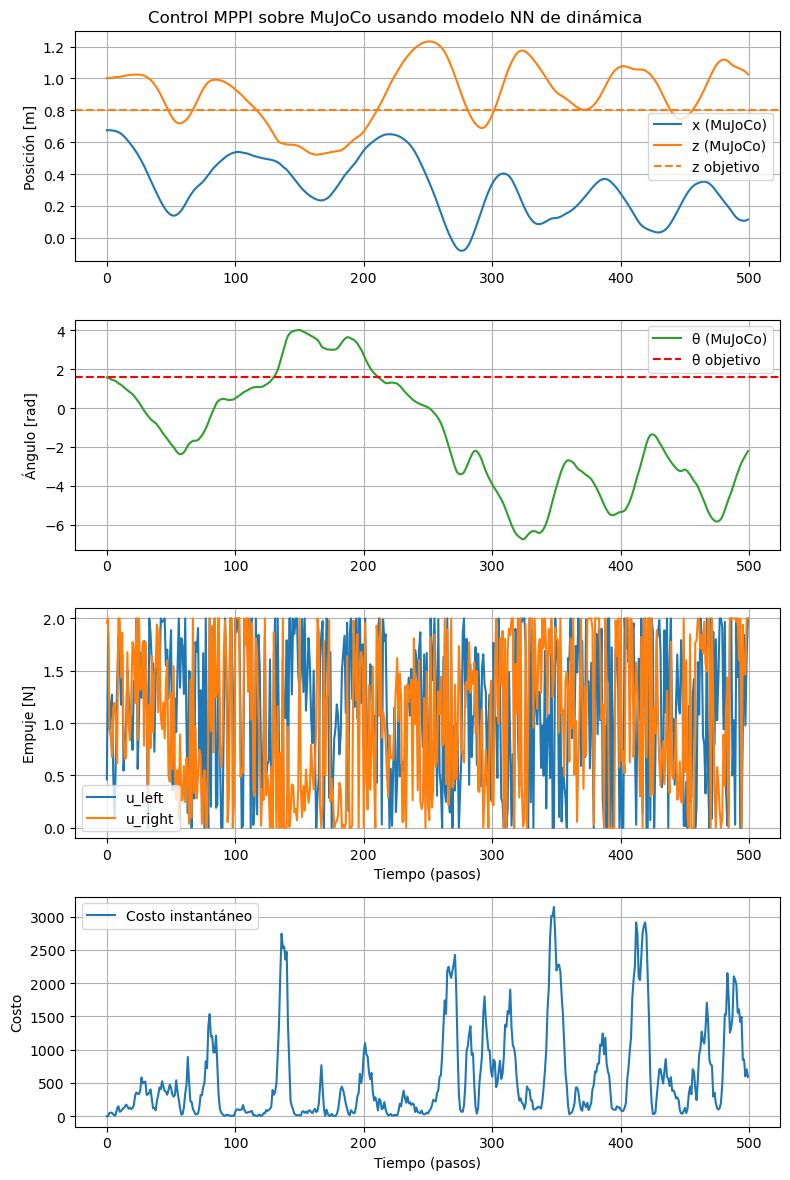

In [180]:
# =====================================================
# 2️⃣ Gráficos de estado / acción / costo
# =====================================================

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np


fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# 1) Posición x, z
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color='C1')
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# 2) Ángulo θ
axes[1].plot(traj_s[:,4], label="θ (MuJoCo)", color='C2')
axes[1].axhline(goal[4], color='r', linestyle='--', label="θ objetivo")
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# 3) Acciones (empujes)
axes[2].plot(traj_u[:,0], label="u_left")
axes[2].plot(traj_u[:,1], label="u_right")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# 4) Costo instantáneo
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo NN de dinámica")
plt.tight_layout()
plt.show()

# =====================================================
# 3️⃣ Animación tipo Pendulum-v1
# =====================================================

fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
plt.close()

HTML(ani.to_html5_video())


In [147]:
print(traj_u[:,0])

[7.3961747e-01 5.1746345e-01 6.8765575e-01 6.8902266e-01 5.2479897e-02
 2.0000000e+00 9.3950516e-01 1.8383346e+00 1.4528170e+00 1.4593985e+00
 9.9121493e-01 6.6704881e-01 1.9833359e+00 1.0588440e+00 1.5878890e+00
 1.4375514e+00 1.7437842e+00 2.0000000e+00 1.3228884e+00 1.8245518e+00
 8.6955875e-01 2.0000000e+00 1.8592378e+00 5.4759836e-01 5.4978931e-01
 7.9271364e-01 2.0000000e+00 1.4692032e+00 1.8279164e+00 1.1402550e+00
 8.3297980e-01 1.4478484e+00 3.4379530e-01 2.0000000e+00 5.3801006e-01
 1.5073333e+00 7.8883582e-01 1.2813058e+00 3.7089831e-01 1.7340100e+00
 1.0090399e+00 9.6406287e-01 5.6925493e-01 1.7537510e+00 2.0000000e+00
 1.4764657e+00 1.9806774e+00 1.3281437e+00 1.0020494e+00 8.1632984e-01
 3.5426638e-01 4.2724609e-01 2.0635651e-01 1.5733705e+00 1.1742240e+00
 9.8027062e-01 1.3944441e+00 1.5205628e+00 1.9946423e+00 0.0000000e+00
 1.3260338e+00 5.7761371e-01 0.0000000e+00 4.3137647e-02 3.8381386e-01
 8.6282331e-01 7.2118938e-01 1.6228788e+00 1.2709424e+00 1.1423677e+00
 1.590

In [4]:
import os, joblib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Crear carpeta si no existe
os.makedirs("data/gp_models", exist_ok=True)

# Entradas = estado + acción   -> (N, 8)
X = np.hstack([states, actions])  # [x, z, ẋ, ż, θ, θ̇, u_left, u_right]
Y = delta_s                       # (N, 6)

# Archivos donde se guardarán los modelos (uno por cada dimensión de delta_s)
model_paths = [f"data/gp_models/gp_model_{i}.pkl" for i in range(Y.shape[1])]

# Kernel compartido
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e-1))

gps = []
all_exist = all(os.path.exists(p) for p in model_paths)

if all_exist:
    print("📂 Cargando modelos GP guardados...")
    for path in model_paths:
        gps.append(joblib.load(path))
    print("✅ Modelos cargados correctamente.")
else:
    print("⚙️ Entrenando nuevos modelos Gaussian Process...")
    for i in tqdm(range(Y.shape[1])):
        gp = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            n_restarts_optimizer=2,
            random_state=0,
        )
        gp.fit(X, Y[:, i])
        gps.append(gp)
        joblib.dump(gp, model_paths[i])
    print("✅ Entrenamiento y guardado completo.")


📂 Cargando modelos GP guardados...
✅ Modelos cargados correctamente.


## Validation and Visualization

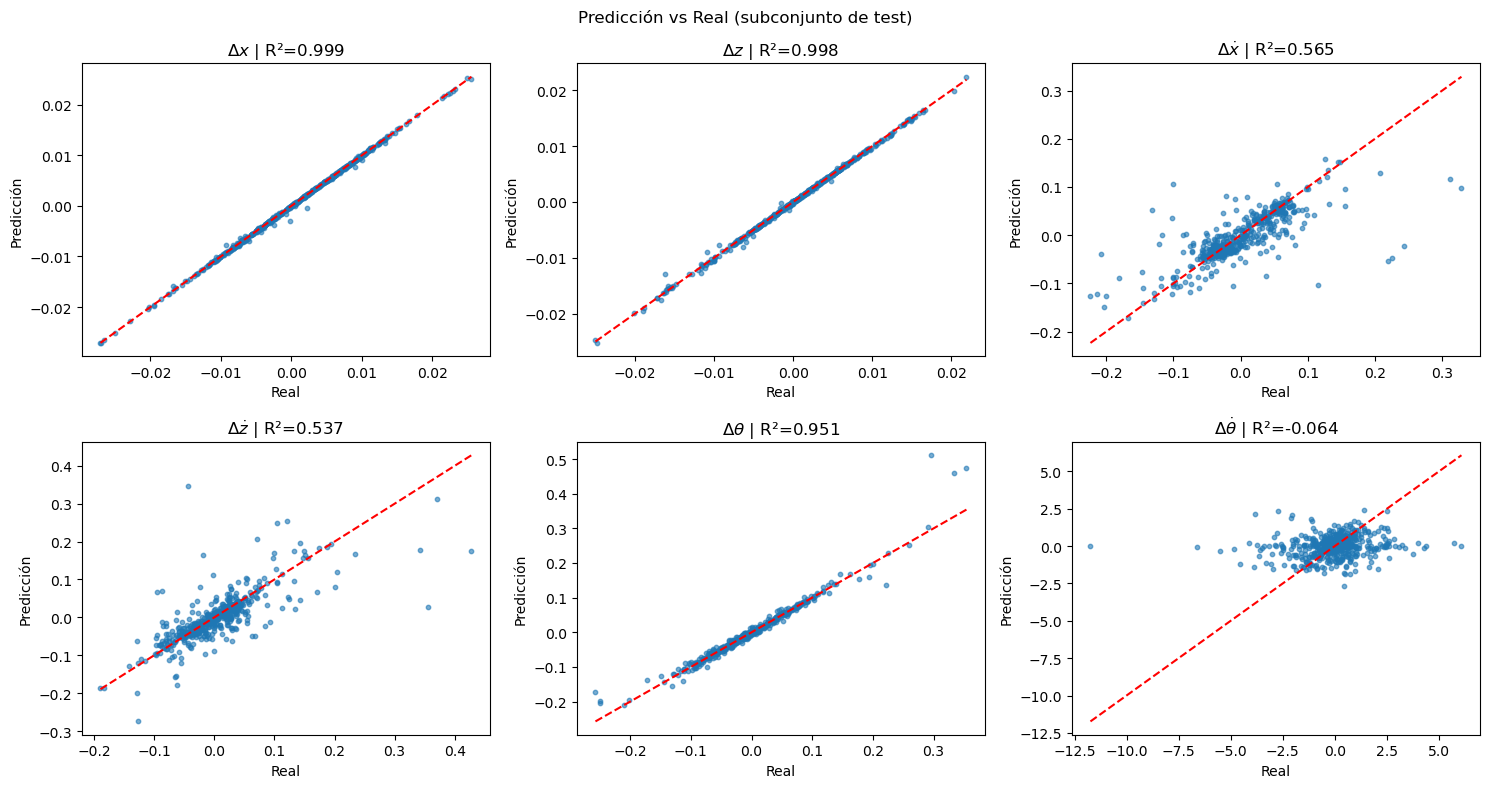

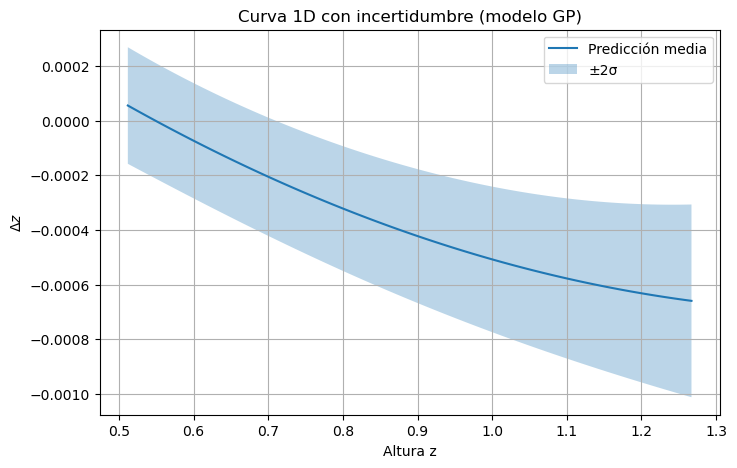

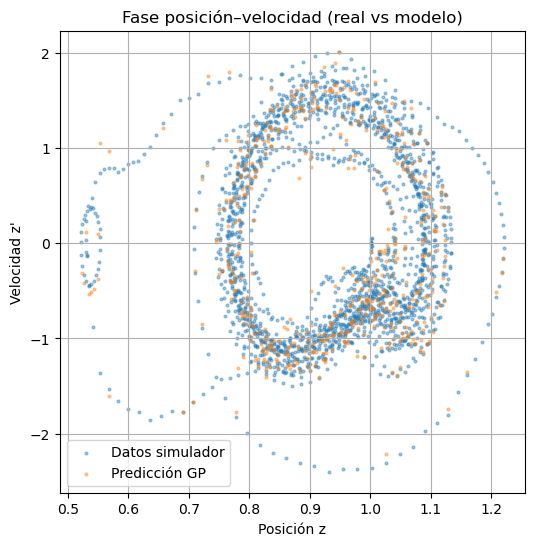

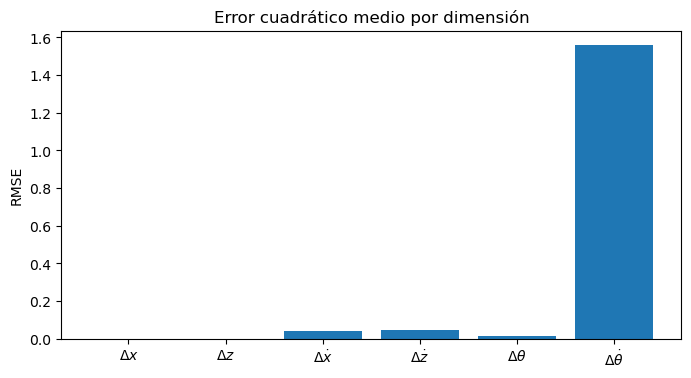

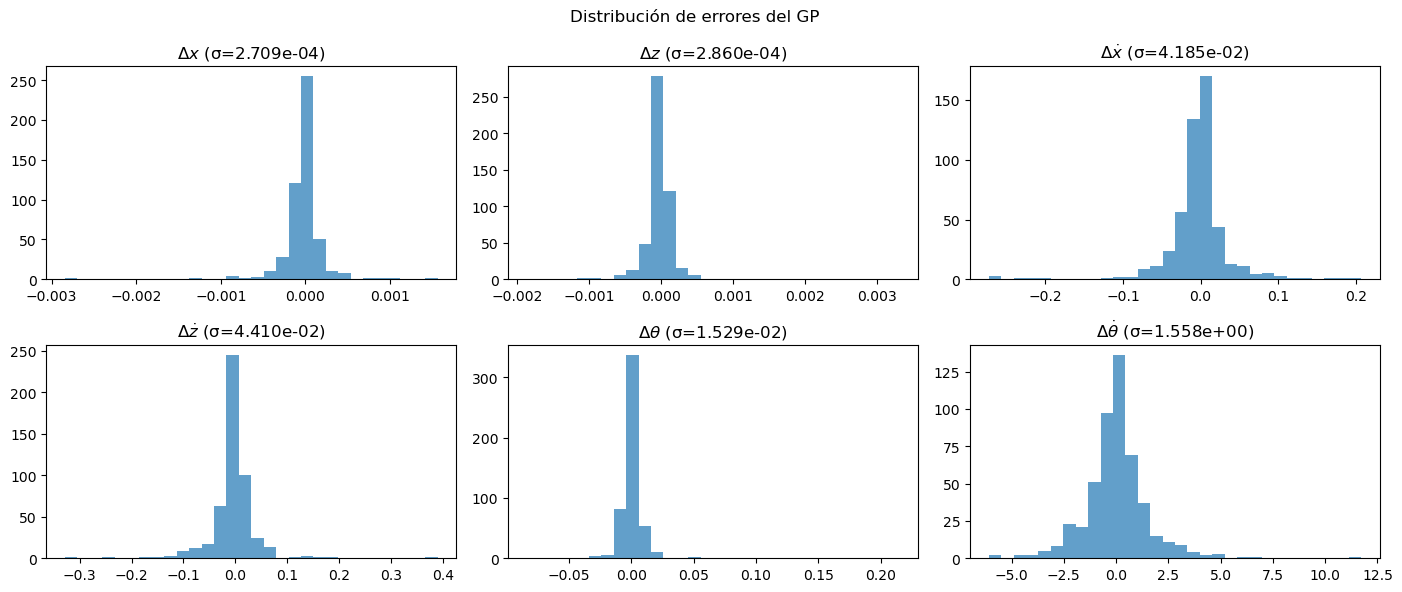

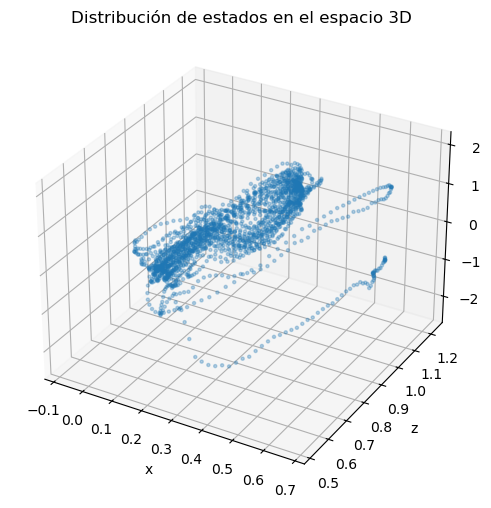

In [83]:
# ===============================================
# 4️⃣ Diagnóstico y visualización del modelo GP
# ===============================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Recalcular predicciones sobre un subconjunto de datos
idx = np.random.choice(len(X), size=500, replace=False)
X_test, Y_true = X[idx], Y[idx]
Y_pred = np.zeros_like(Y_true)

# Predicciones por modelo
for i in range(Y_true.shape[1]):
    Y_pred[:, i] = gps[i].predict(X_test)

# --------------------------
# 1️⃣ Scatter: Pred vs Real
# --------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$\Delta x$', r'$\Delta z$', r'$\Delta \dot{x}$', r'$\Delta \dot{z}$', r'$\Delta \theta$', r'$\Delta \dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(Y_true[:, i], Y_pred[:, i], s=10, alpha=0.6)
    ax.plot([Y_true[:, i].min(), Y_true[:, i].max()],
            [Y_true[:, i].min(), Y_true[:, i].max()], 'r--')
    ax.set_title(f"{labels[i]} | R²={r2_score(Y_true[:, i], Y_pred[:, i]):.3f}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Predicción")

plt.suptitle("Predicción vs Real (subconjunto de test)")
plt.tight_layout()
plt.show()

# --------------------------
# 2️⃣ Curva 1D con incertidumbre
# --------------------------
# Elegimos una variable y analizamos su dependencia con z (altura)
var_idx = 1  # Ejemplo: delta z
dim = 1      # Analizamos dependencia con z

# Barrido de una variable (z) manteniendo el resto fijo
z_values = np.linspace(X[:, dim].min(), X[:, dim].max(), 100)
X_base = np.mean(X, axis=0)
X_curve = np.tile(X_base, (100, 1))
X_curve[:, dim] = z_values

# Predicción con incertidumbre
y_mean, y_std = gps[var_idx].predict(X_curve, return_std=True)

plt.figure(figsize=(8,5))
plt.plot(z_values, y_mean, label='Predicción media')
plt.fill_between(z_values, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.3, label='±2σ')
plt.xlabel("Altura z")
plt.ylabel(f"{labels[var_idx]}")
plt.title("Curva 1D con incertidumbre (modelo GP)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 3️⃣ Fase: posición vs velocidad (modelo vs datos)
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(states[:,1], states[:,3], s=4, alpha=0.4, label="Datos simulador")
plt.scatter(states[idx,1], states[idx,3]+Y_pred[:,3], s=4, alpha=0.4, label="Predicción GP")
plt.xlabel("Posición z")
plt.ylabel("Velocidad z'")
plt.title("Fase posición–velocidad (real vs modelo)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 4️⃣ Errores por variable
# --------------------------
errors = Y_pred - Y_true
rmse = np.sqrt(np.mean(errors**2, axis=0))

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(range(6), rmse)
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_ylabel("RMSE")
ax.set_title("Error cuadrático medio por dimensión")
plt.show()

# --------------------------
# 5️⃣ Distribución de errores (histogramas)
# --------------------------
fig, axes = plt.subplots(2,3, figsize=(14,6))
for i, ax in enumerate(axes.flat):
    ax.hist(errors[:,i], bins=30, alpha=0.7)
    ax.set_title(f"{labels[i]} (σ={np.std(errors[:,i]):.3e})")
plt.suptitle("Distribución de errores del GP")
plt.tight_layout()
plt.show()


# --------------------------
# 6️⃣ Visualización 3D de los estados
# --------------------------
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(states[:,0], states[:,1], states[:,3], s=5, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("z'")
ax.set_title("Distribución de estados en el espacio 3D")
plt.show()


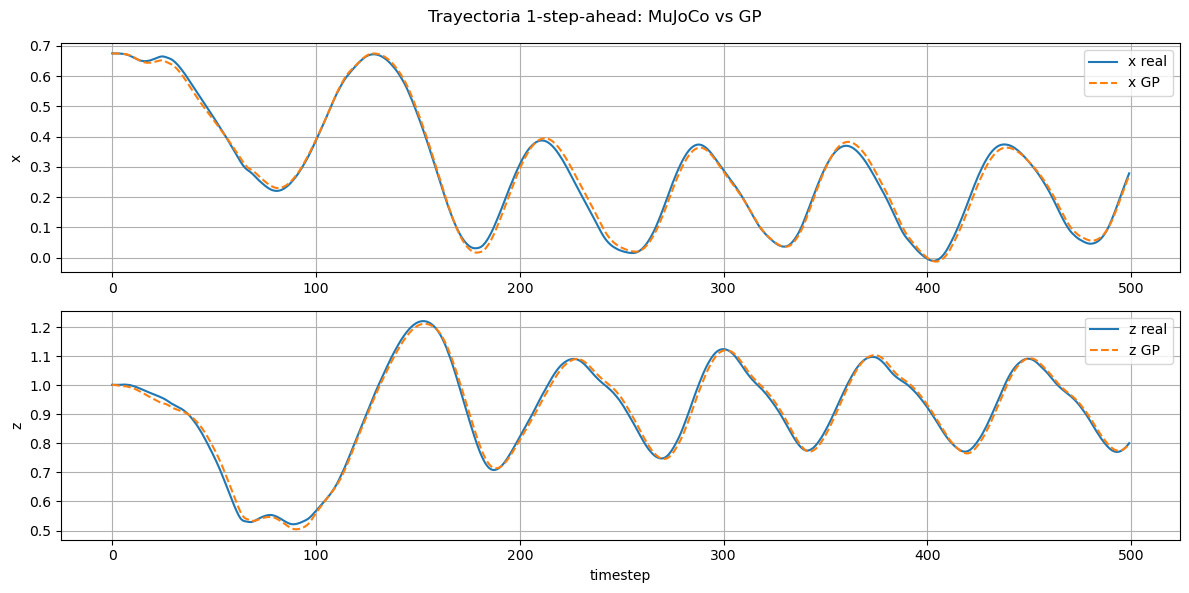

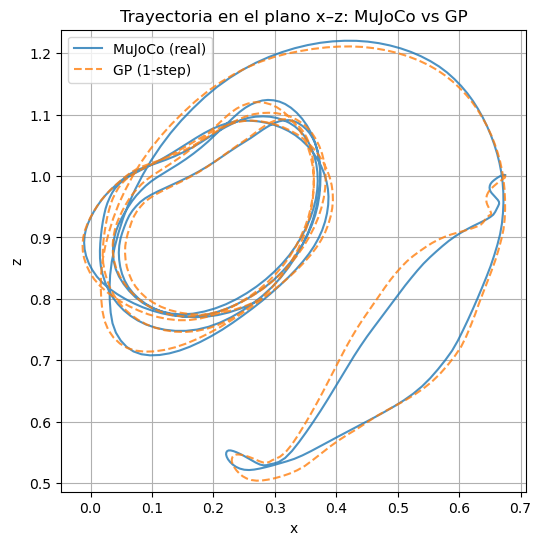

In [84]:
# Elegimos una secuencia continua de índices
t0 = 0
T = 500
X_seq = X[t0:t0+T]
Y_seq_true = Y[t0:t0+T]

Y_seq_pred = np.zeros_like(Y_seq_true)
for i in range(Y_seq_true.shape[1]):
    Y_seq_pred[:, i] = gps[i].predict(X_seq)

# Reconstruimos el estado siguiente
s_seq      = states[t0:t0+T]        # s_t
s_seq_true = states[t0+1:t0+T+1]    # s_{t+1} real
s_seq_pred = s_seq + Y_seq_pred     # s_{t+1} predicho

time = np.arange(T)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(time, s_seq_true[:,0], label="x real")
plt.plot(time, s_seq_pred[:,0], '--', label="x GP")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_seq_true[:,1], label="z real")
plt.plot(time, s_seq_pred[:,1], '--', label="z GP")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Trayectoria 1-step-ahead: MuJoCo vs GP")
plt.tight_layout()
plt.show()




plt.figure(figsize=(6,6))

# Trayectoria real (MuJoCo)
plt.plot(s_seq_true[:, 0],  # x
         s_seq_true[:, 1],  # z
         label="MuJoCo (real)", alpha=0.8)

# Trayectoria predicha por el GP (1-step-ahead)
plt.plot(s_seq_pred[:, 0],  # x
         s_seq_pred[:, 1],  # z
         '--', label="GP (1-step)", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: MuJoCo vs GP")
plt.legend()
plt.grid(True)
plt.axis('equal')   # para que las escalas de x y z no se deformen
plt.show()



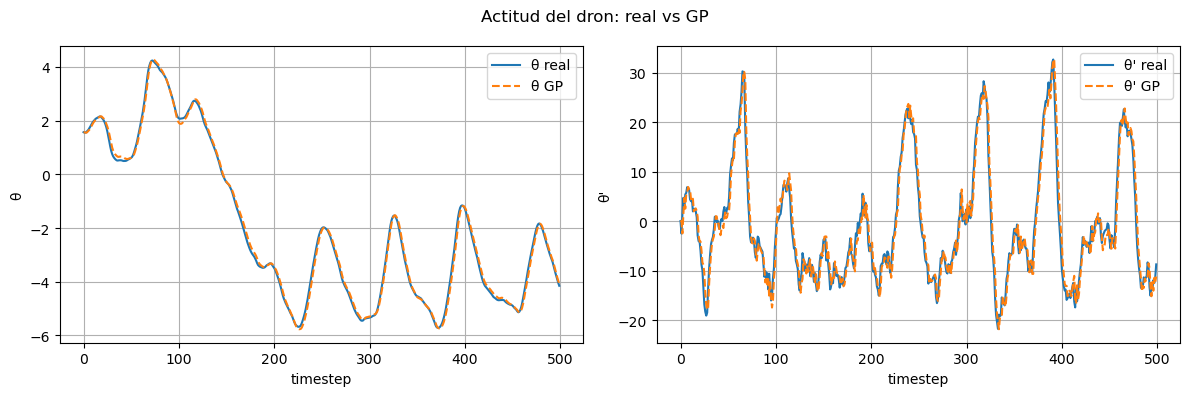

In [85]:

# ==============================================
# 5️⃣ Visualización de actitudes (θ y θ') real vs GP
# ==============================================

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, s_seq_true[:,4], label="θ real")
plt.plot(time, s_seq_pred[:,4], '--', label="θ GP")
plt.xlabel("timestep")
plt.ylabel("θ")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(time, s_seq_true[:,5], label="θ' real")
plt.plot(time, s_seq_pred[:,5], '--', label="θ' GP")
plt.xlabel("timestep")
plt.ylabel("θ'")
plt.grid(True)
plt.legend()

plt.suptitle("Actitud del dron: real vs GP")
plt.tight_layout()
plt.show()


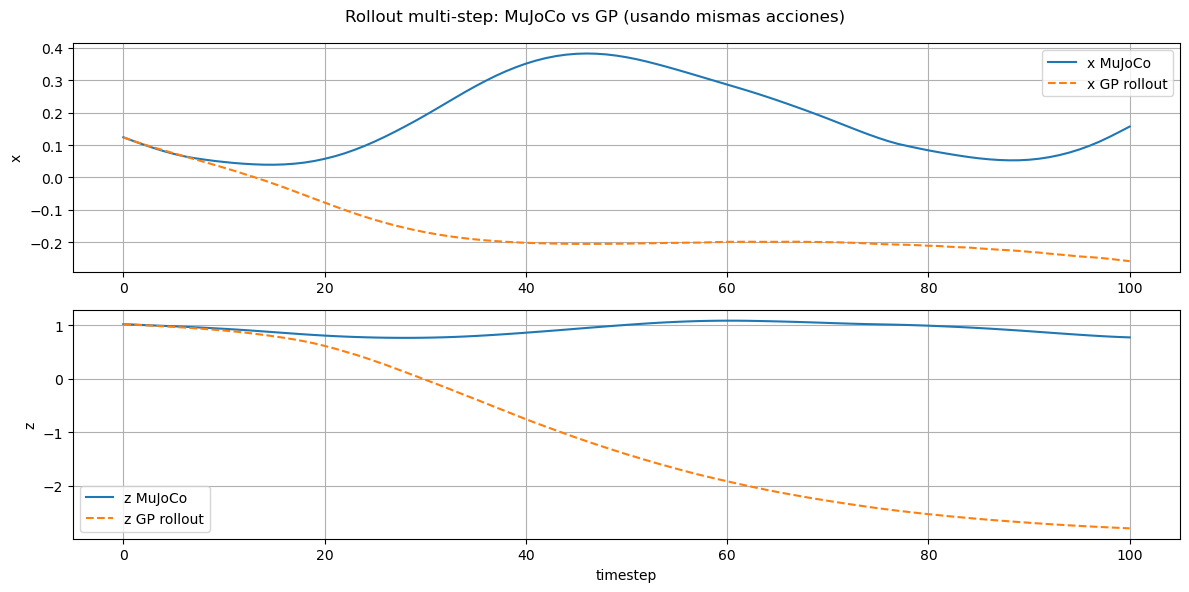

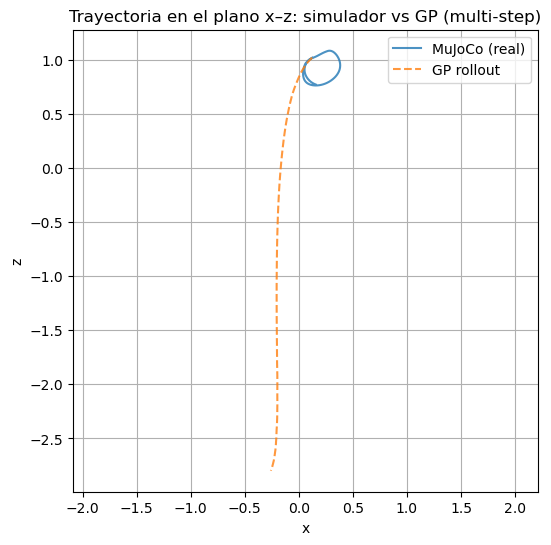

In [86]:
# ===============================================
# 5️⃣ Rollout multi-step usando el modelo GP
# ===============================================

t0 = 1000
T = 100

s_true_traj = states[t0:t0+T+1]       # s_t ... s_{t+T}
a_traj      = actions[t0:t0+T]        # a_t ... a_{t+T-1}

# Rollout del GP
s_gp = [s_true_traj[0].copy()]        # empezamos en s_t0 real
s    = s_true_traj[0].copy()

for k in range(T):
    s_k   = s
    a_k   = a_traj[k]
    x_in  = np.hstack([s_k, a_k]).reshape(1, -1)

    # predecimos Δs
    delta_pred = np.array([gp.predict(x_in)[0] for gp in gps])
    s          = s_k + delta_pred
    s_gp.append(s.copy())

s_gp = np.array(s_gp)                 # shape (T+1, dim_s)

time = np.arange(T+1)


plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(time, s_true_traj[:,0], label="x MuJoCo")
plt.plot(time, s_gp[:,0], '--', label="x GP rollout")
plt.ylabel("x")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time, s_true_traj[:,1], label="z MuJoCo")
plt.plot(time, s_gp[:,1], '--', label="z GP rollout")
plt.ylabel("z")
plt.xlabel("timestep")
plt.legend()
plt.grid(True)

plt.suptitle("Rollout multi-step: MuJoCo vs GP (usando mismas acciones)")
plt.tight_layout()
plt.show()


# Visualización de la trayectoria en el plano x–z

plt.figure(figsize=(6,6))

plt.plot(s_true_traj[:,0], s_true_traj[:,1],
         label="MuJoCo (real)", alpha=0.8)

plt.plot(s_gp[:,0], s_gp[:,1],
         '--', label="GP rollout", alpha=0.8)

plt.xlabel("x")
plt.ylabel("z")
plt.title("Trayectoria en el plano x–z: simulador vs GP (multi-step)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


#  MPPI Controller

In [65]:
# ==============================================
# 6️⃣ Helper functions para control MPPI
# ==============================================

import numpy as np

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
act_dim   = 2   # [u_left, u_right]


def predict_next_gp(s, a, gps):
    """
    s: estado actual (6,)
    a: acción actual (2,)
    gps: lista de 6 modelos GP, cada uno predice una componente de Δs
    devuelve: s_next (6,)
    """
    x = np.hstack([s, a]).reshape(1, -1)  # (1, 8)
    delta = np.zeros(state_dim)
    for i, gp in enumerate(gps):
        delta[i] = gp.predict(x)[0]
    return s + delta


In [ ]:
# ==============================================
# 7️⃣ Control MPPI usando el modelo GP
# ===============================================

def cost_function(
    s, a,
    goal=np.array([0.0, 1.0, 0, 0, 1.57, 0]),
    weights=None
):
    """
    s = [x, z, x_dot, z_dot, theta, theta_dot]
    a = [u1, u2]
    """
    if weights is None:
        weights = dict(
            x_pos=0.0,
            z_pos=3.0,
            x_vel=0.5,
            z_vel=1.0,
            theta=0.0,
            theta_dot=1.0,
            ctrl_effort=0.1,
            ctrl_asym=0.05,
        )

    x_err        = s[0] - goal[0]
    z_err        = s[1] - goal[1]
    x_vel_err    = s[2]
    z_vel_err    = s[3]
    theta_err    = s[4] - goal[4]
    theta_dot_err = s[5]

    ctrl_effort  = np.linalg.norm(a - np.array([1.0, 1.0]))
    ctrl_asym    = np.abs(a[0] - a[1])

    cost = (
        weights["x_pos"]      * x_err**2
        + weights["z_pos"]    * z_err**2
        + weights["x_vel"]    * x_vel_err**2
        + weights["z_vel"]    * z_vel_err**2
        + weights["theta"]    * theta_err**2
        + weights["theta_dot"]* theta_dot_err**2
        + weights["ctrl_effort"] * ctrl_effort**2
        + weights["ctrl_asym"]   * ctrl_asym**2
    )
    return cost


def mppi_control(
    s0,
    u_mean,
    gps,
    goal,
    weights,
    N=80,
    H=20,
    lambda_=1.0,
    sigma_u=0.2
):
    """
    s0:    estado actual (6,)
    u_mean: secuencia nominal (H, 2)
    gps:   lista de GPs
    goal:  estado objetivo
    weights: pesos de costo
    """
    noise   = np.random.randn(N, H, 2) * sigma_u
    costs   = np.zeros(N)
    actions = np.zeros((N, H, 2))

    for n in range(N):
        s = np.copy(s0)
        cost = 0.0
        for t in range(H):
            u_t = np.clip(u_mean[t] + noise[n, t], u_min, u_max)
            s = predict_next_gp(s, u_t, gps)
            cost += cost_function(s, u_t, goal, weights)
            actions[n, t] = u_t
        costs[n] = cost

    # Softmin (importancia)
    beta = np.min(costs)
    w = np.exp(-(costs - beta) / lambda_)
    w /= np.sum(w)

    # Actualizar secuencia nominal
    for t in range(H):
        u_mean[t] = np.sum(w[:, None] * actions[:, t, :], axis=0)
    u_mean = np.clip(u_mean, u_min, u_max)

    # Receding horizon
    u_opt = u_mean[0].copy()
    u_mean[:-1] = u_mean[1:]
    u_mean[-1]  = u_mean[-2]

    return u_opt, u_mean # acción óptima y secuencia actualizada



In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import mujoco as mj

# =====================================================
# 0️⃣ Parámetros MPPI y objetivo
# =====================================================

H = 10         # pasos de predicción
N = 100          # rollouts (muestras)
lambda_ = 1.0
sigma_u = 0.2

u_min = np.array([0.0, 0.0])
u_max = np.array([2.0, 2.0])
u_init = np.array([1.0, 1.0])

goal = np.array([0.0, 1.0, 0, 0, 0, 0])

weights_custom = dict(
    x_pos=0.5,  z_pos=4.0,
    x_vel=0.5,  z_vel=1.0,
    theta=0.5,  theta_dot=0.5,
    ctrl_effort=0.1, ctrl_asym=0.05
)

T = 500   # pasos de control / frames

width, height = 640, 480

# Para guardar resultados
traj_s, traj_u, traj_cost = [], [], []
frames = []

# =====================================================
# 1️⃣ Context manager del Renderer (se auto-cierra)
# =====================================================

with mj.Renderer(model, height=height, width=width) as renderer:
    # Cámara
    cam = mj.MjvCamera()
    mj.mjv_defaultCamera(cam)

    # Ajusta estos valores (idealmente los que encontraste en tu test)
    cam.lookat   = np.array([0.3, 0.0, 0.8])
    cam.distance = 3.0
    cam.elevation = -20.0
    cam.azimuth   = 90.0

    # Reset simulador
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    prev_theta = None
    s, prev_theta = get_state_from_sensors(data, prev_theta)

    u_mean = np.tile(u_init, (H, 1))

    # 🔁 Loop de control + simulación + render
    for t in tqdm(range(T)):
        # --- MPPI: acción óptima usando el GP como modelo interno ---
        u, u_mean = mppi_control(
            s0     = s,
            u_mean = u_mean,
            gps    = gps,
            goal   = goal,
            weights= weights_custom,
            N      = N,
            H      = H,
            lambda_= lambda_,
            sigma_u= sigma_u
        )

        # --- Aplicar acción en MuJoCo ---
        data.ctrl[:] = u
        mj.mj_step(model, data)

        # --- Nuevo estado real ---
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # --- Log para análisis ---
        traj_s.append(s_next)
        traj_u.append(u)
        traj_cost.append(cost_function(s, u, goal, weights_custom))
        s = s_next.copy()

        # --- Renderizar frame ---
        renderer.update_scene(data, cam)
        rgb = renderer.render()
        frames.append(rgb.copy())

# 💡 Aquí ya se llamó automáticamente a renderer.close()

traj_s = np.array(traj_s)
traj_u = np.array(traj_u)
traj_cost = np.array(traj_cost)



100%|██████████| 500/500 [39:47<00:00,  4.78s/it]


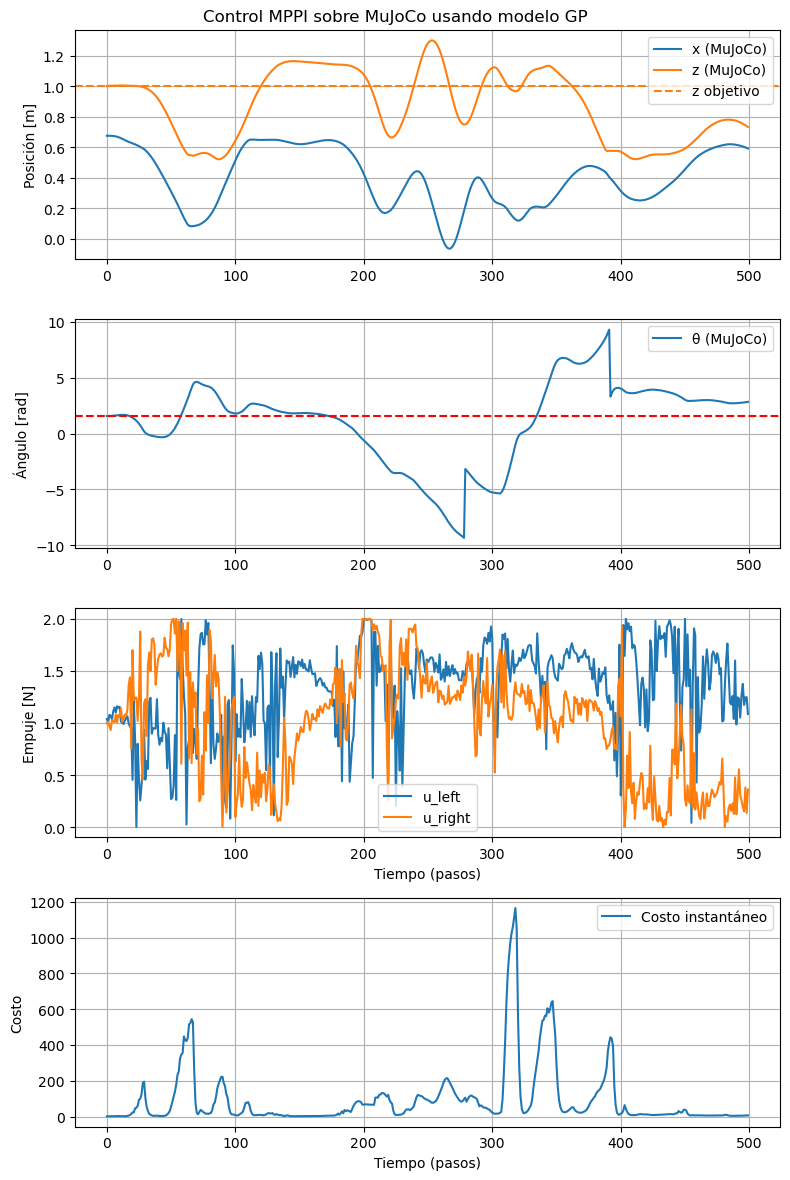

In [88]:
# =====================================================
# 2️⃣ Gráficos de estado / acción / costo
# =====================================================

fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# Posición
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color ='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color ='C1')
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# Ángulo
axes[1].plot(traj_s[:,4], label="θ (MuJoCo)")
axes[1].axhline(np.pi/2, color='r', linestyle='--')
axes[1].set_ylabel("Ángulo [rad]")
axes[1].legend()
axes[1].grid()

# Control
axes[2].plot(traj_u[:,0], label="u_left")
axes[2].plot(traj_u[:,1], label="u_right")
axes[2].set_ylabel("Empuje [N]")
axes[2].set_xlabel("Tiempo (pasos)")
axes[2].legend()
axes[2].grid()

# Costo
axes[3].plot(traj_cost, label="Costo instantáneo")
axes[3].set_ylabel("Costo")
axes[3].set_xlabel("Tiempo (pasos)")
axes[3].legend()
axes[3].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP")
plt.tight_layout()
plt.show()

# =====================================================
# 3️⃣ Animación tipo Pendulum-v1
# =====================================================

fig = plt.figure()
img = plt.imshow(frames[0])

def animate(i):
    img.set_data(frames[i])
    return [img]

ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
plt.close()

HTML(ani.to_html5_video())